<a href="https://colab.research.google.com/github/jmmzhng-pro/DSCI_631_Project/blob/main/01_Data_Acquisition_EDA/Data_Acquisition_and_EDA_FOMC_Textual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DSCI 631 Final Project**

- Group member
    - Name: Jonathan Watkins
    - Email: jfw68@drexel.edu
- Group member
    - Name: Jake Jarosik
    - Email: jj3268@drexel.edu
- Group member
    - Name: Jimmy Zhang
    - Email: jz876@drexel.edu


# **System Setup**

In [ ]:
# Comment in and out as need
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# install packages here
%pip install transformers
%pip install spacy
%pip install yfinance --upgrade --no-cache-dir
%pip install FedTools
%pip install tokenization
%pip install bert
%pip install FomcStatement
%pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 681.0 kB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.32
    Uninstalling yfinance-0.2.32:
      Successfully uninstalled yfinance-0.2.32
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert: filename=bert-2.2.0-py3-none-any.whl size=3744 sha256=08152d7102ed5a285a663ae5e7b16398326b2f7dec7c51bbc93a18ce9221c72a
  Stored in directory: /root/.cache/pip/wheels/d0/97/c8/5775d57c323970511488d9b53ce66cf0ded394fe4b4f6e0afb
  Created wheel for erlastic: filename=erlastic-2.0.0-py3-none-any.whl size=6779 sha256=93a11db04e96137d0a53e6cc094d8391c818c3837ef4c94b9eeae5ab9060e180
  Stored in directory: /root/.cache/pip/wheels/f5/ca/b1/ce71c2e0e9e0df3786697d06d53574be03ef86cd4fb0e2cb99
Successfully built bert erlastic
ERROR: Could not find a version that satisfies the requirement FomcStatement (from versions: none)
ERROR: No matching distributi

In [ ]:
# import standard modules here
import sys
import os
import datetime
import requests
from bs4 import BeautifulSoup
import bs4
import nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import string
import pickle
import threading
import torch
import transformers
import tokenization
import bert

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# import standard modules with aliases here
import random as ra
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
import spacy as sc
import tensorflow as tf
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# import individual objects from standard modules here
from dateutil import parser
from datetime import date

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from scipy.stats import jarque_bera

In [ ]:
# import non-standard modules / python scripts / objects here
sys.path.append('/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/Final Submission/fomc_get_data')
from FomcStatement import FomcStatement

# **Data Acquisition for FOMC Textual Data**

In [ ]:
# this function access stock price data via the yahoo finance api and save it as a csv to to the specified path.
def download_stock_price(myTicker = '^GSPC', start_time='2008-01-01', path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/StockPrice/'):
  myData = yf.Ticker(myTicker).history(start=start_time)
  myData.to_csv(path + myTicker + '.csv')
  return myData

In [ ]:
# usage
mrk = download_stock_price('MRK')
mrk.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2008-01-02 00:00:00-05:00,31.566242,31.761666,30.996259,31.142826,12287276,0.0,0.0
2008-01-03 00:00:00-05:00,31.186254,31.452246,30.996260,31.115685,8831810,0.0,0.0
2008-01-04 00:00:00-05:00,30.914808,31.186229,30.806241,30.860523,10469625,0.0,0.0
2008-01-07 00:00:00-05:00,30.990812,31.712791,30.914814,31.441372,11874783,0.0,0.0
2008-01-08 00:00:00-05:00,31.533660,32.945047,31.495660,32.385921,21523824,0.0,0.0


In [ ]:
# this function gets a list of the current S&P 500 constituents from web scrape
def download_s_and_p_500_data (path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/'):
  link = (
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks"
  )
  data = pd.read_html(link, header=0)[0]
  data.to_csv(path + "constituents.csv", index=False)
  return data

In [ ]:
# this function access fomc statements using web scrapping, provided through the imported custom python module. do not run if the data is already downloaded.
def download_Fomc_statements(start_year= datetime.datetime(2008, 1, 1), path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/FOMCData/'):
  statementHandler = FomcStatement()
  statementHandler.verbose = False
  all_statements = statementHandler.get_contents()
  statements_of_interest = all_statements[all_statements['date'] >= start_year]
  for i, row in statements_of_interest.iterrows():
    textfilepath = path + row['date'].strftime('%Y-%m-%d') + '.txt'
    with open(textfilepath, 'w') as fileHandler:
      fileHandler.write(row['contents'])
  return statements_of_interest

In [ ]:
#call function
download_Fomc_statements()

Getting links from archive pages...
There are total  225  links for  statement


,date,contents,speaker,title
89,2008-01-21,"The Federal Reserve, the central bank of the U...",Ben Bernanke,FOMC Statement
90,2008-01-30,"The Federal Reserve, the central bank of the U...",Ben Bernanke,FOMC Statement
91,2008-03-10,"The Federal Reserve, the central bank of the U...",Ben Bernanke,FOMC Statement
92,2008-03-18,"The Federal Reserve, the central bank of the U...",Ben Bernanke,FOMC Statement
93,2008-04-30,"The Federal Reserve, the central bank of the U...",Ben Bernanke,FOMC Statement
...,...,...,...,...
220,2023-05-03,"The Federal Reserve, the central bank of the U...",other,FOMC Statement
221,2023-06-14,"The Federal Reserve, the central bank of the U...",other,FOMC Statement
222,2023-07-26,"The Federal Reserve, the central bank of the U...",other,FOMC Statement
223,2023-09-20,"The Federal Reserve, the central bank of the U...",other,FOMC Statement


In [ ]:
# use this function to load FOMC statements that are already saved
def load_Fomc_textfile(filename, path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/FOMCData/'):
  filepath = path + filename
  with open(filepath, 'r') as fileHandler:
    myFileContents = fileHandler.read()
  return myFileContents

In [ ]:
# usage
mar2009_statement = load_Fomc_textfile('2009-03-18.txt')
mar2009_statement

"The Federal Reserve, the central bank of the United States, provides\n          the nation with a safe, flexible, and stable monetary and financial\n          system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[SECTION]\n\nMonetary Policy Principles and Practice\n\n[SECTION]\n\nPolicy Implementation\n\n[SECTION]\n\nReports\n\n[SECTION]\n\nReview of Monetary Policy Strategy, Tools, and Communications\n\n[SECTION]\n\nInstitution Supervision\n\n[SECTION]\n\nReports\n\n[SECTION]\n\nReporting Forms\n\n[SECTION]\n\nSupervision & Regulation Letters\n\n[SECTION]\n\nBanking Applications & Legal Developments\n\n[SECTION]\n\nRegulatory Resources\n\n[SECTION]\n\nBanking & Data Structure\n\n[SECTION]\n\nFinancial Stability Assessments\n\n[SECTION]\n\nFinancial Stability Coordination & Actions\n\n[SECTION]\n\nReports\n\n[SECTION]\n\nRegulations & Statutes\n\n[SECTION]\n\nPayment Policies\n\n[SECTION]\n\nReserve Bank Payment Services & Data\n\n[SECTION]\n\nFinancial Market Utilities & Infrastr

In [ ]:
# Now let's process the textual data:
# first, tokenize words
def preprocess_fomc_statement(file):
    # loading/ pre-processing data
    fomc_statement = load_Fomc_textfile(file, path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/FOMCData/')
    fomc_statement = fomc_statement.lower()
    fomc_statement = fomc_statement.translate(str.maketrans('', '', string.punctuation))

    # Tokenize words
    words = word_tokenize(fomc_statement)
    stop_words = set(stopwords.words('english'))
    stop_words.update(["federal", "reserve", "financial", "committee", "market", "would", "also"])
    filtered_words = [word for word in words if word not in stop_words]

    return filtered_words

example_statement_filename = '2009-03-18.txt'
preprocessed_words = preprocess_fomc_statement(example_statement_filename)
preprocessed_words

['central',
 'bank',
 'united',
 'states',
 'provides',
 'nation',
 'safe',
 'flexible',
 'stable',
 'monetary',
 'system',
 'section',
 'open',
 'section',
 'monetary',
 'policy',
 'principles',
 'practice',
 'section',
 'policy',
 'implementation',
 'section',
 'reports',
 'section',
 'review',
 'monetary',
 'policy',
 'strategy',
 'tools',
 'communications',
 'section',
 'institution',
 'supervision',
 'section',
 'reports',
 'section',
 'reporting',
 'forms',
 'section',
 'supervision',
 'regulation',
 'letters',
 'section',
 'banking',
 'applications',
 'legal',
 'developments',
 'section',
 'regulatory',
 'resources',
 'section',
 'banking',
 'data',
 'structure',
 'section',
 'stability',
 'assessments',
 'section',
 'stability',
 'coordination',
 'actions',
 'section',
 'reports',
 'section',
 'regulations',
 'statutes',
 'section',
 'payment',
 'policies',
 'section',
 'bank',
 'payment',
 'services',
 'data',
 'section',
 'utilities',
 'infrastructures',
 'section',
 'researc

['central', 'bank', 'united', 'states', 'provides', 'nation', 'safe', 'flexible', 'stable', 'monetary', 'system', 'section', 'open', 'section', 'monetary', 'policy', 'principles', 'practice', 'section', 'policy', 'implementation', 'section', 'reports', 'section', 'review', 'monetary', 'policy', 'strategy', 'tools', 'communications', 'section', 'institution', 'supervision', 'section', 'reports', 'section', 'reporting', 'forms', 'section', 'supervision', 'regulation', 'letters', 'section', 'banking', 'applications', 'legal', 'developments', 'section', 'regulatory', 'resources', 'section', 'banking', 'data', 'structure', 'section', 'stability', 'assessments', 'section', 'stability', 'coordination', 'actions', 'section', 'reports', 'section', 'regulations', 'statutes', 'section', 'payment', 'policies', 'section', 'bank', 'payment', 'services', 'data', 'section', 'utilities', 'infrastructures', 'section', 'research', 'committees', 'forums', 'section', 'working', 'papers', 'notes', 'section'

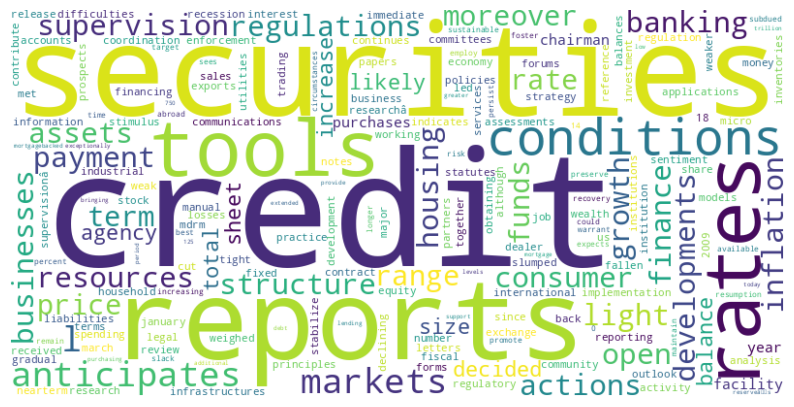

In [ ]:
# let's make word clouds

def analyze_word_frequencies(preprocessed_words, verbose = True):
    # Get a set of English stopwords and punctuation characters
    stop_words = set(stopwords.words('english'))
    punctuations = set(string.punctuation)

    # Filter out stop words and punctuations from the preprocessed words
    filtered_words = [word for word in preprocessed_words if word not in stop_words and word not in punctuations]
    if verbose == True:
      print(filtered_words)

    # List of common words to filter out
    common_words_to_filter = ["federal", "reserve", "central", "bank", "united", "states", "provides",
                              "nation", "safe", "flexible", "stable", "monetary", "financial", "system",
                              "section", "economic", "policy", "data", "billion", "stability"]

    # Filter out common words from the filtered words
    filtered_words = [word for word in filtered_words if word.lower() not in common_words_to_filter]

    # Calculate word frequencies
    word_freq = Counter(filtered_words)

    # Display the 20 most common words
    if verbose:
      print("Most common words:")
      print(word_freq.most_common(20))

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return

# Call the function with preprocessed words
analyze_word_frequencies(preprocessed_words)


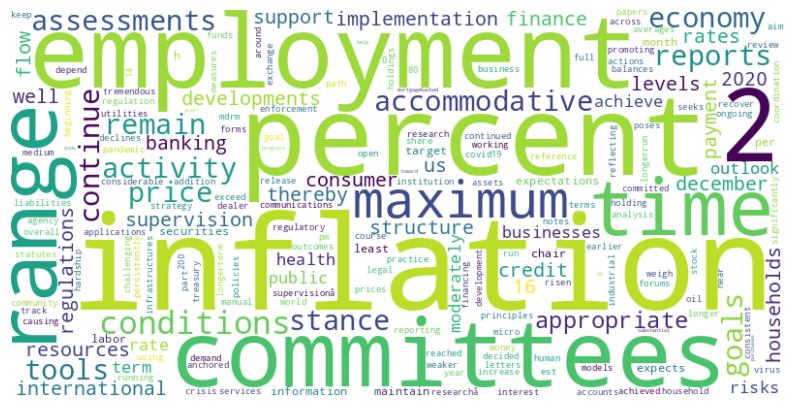

In [ ]:
analyze_word_frequencies(preprocess_fomc_statement('2020-12-16.txt'), False)

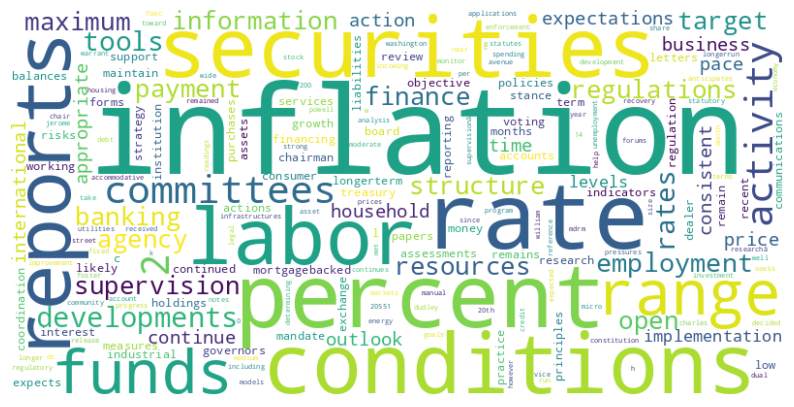

In [ ]:
# let's make a word cloud of all downloaded / retrieved FOMC statements
dir_path_to_fomc_statements = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/FOMCData'
preprocessed_words_all = []
for statement in os.listdir(dir_path_to_fomc_statements):
  preprocessed_words_all += preprocess_fomc_statement(statement)
analyze_word_frequencies(preprocessed_words_all, False)